Here we'll first be loading the FC matrices and explore their structure

In [1]:
#using read_dataset from Datasets/FC/create_dataset.py to read the dataset
from Datasets.FC.create_dataset import read_dataset

ModuleNotFoundError: No module named 'torch_geometric'

In [2]:
dataset = read_dataset()

In [3]:
#ok, let's explore the data a bit more
#dataset is a list object of torch_geometric.data objects

#let's see the first element
print(dataset[0])

#it's a dictionary object, let's see the keys
print(dataset[0].keys())

#ok, let's see the values
print(dataset[0].values())

#it has 4 keys, 'x', 'edge_index', 'edge_attr' and 'y' where y=0 menas the patient is healthy and y=1 means the patient has Autism Spectrum Disorder (ASD)
"""graph = Data(x=ROI.reshape(-1,116).float(),
                     edge_index=G.indices().reshape(2,-1).long(),
                     edge_attr=G.values().reshape(-1,1).float(),
                     y=y.long())"""

#how much data do we have?
len(dataset)


Data(x=[116, 116], edge_index=[2, 1016], edge_attr=[1016, 1], y=[1])
['edge_index', 'y', 'edge_attr', 'x']
ValuesView({'x': tensor([[ 0.0000,  0.4543,  0.2477,  ...,  0.1753,  0.2247, -0.1751],
        [ 0.4543,  0.0000, -0.2204,  ..., -0.1947, -0.2258, -0.1434],
        [ 0.2477, -0.2204,  0.0000,  ..., -0.0521, -0.0804, -0.2025],
        ...,
        [ 0.1753, -0.1947, -0.0521,  ...,  0.0000,  0.6875, -0.1364],
        [ 0.2247, -0.2258, -0.0804,  ...,  0.6875,  0.0000,  0.0929],
        [-0.1751, -0.1434, -0.2025,  ..., -0.1364,  0.0929,  0.0000]]), 'edge_index': tensor([[  0,   0,   0,  ..., 114, 115, 115],
        [  1,  10,  12,  ..., 113,  94, 109]]), 'edge_attr': tensor([[0.4543],
        [0.5913],
        [0.4224],
        ...,
        [0.6875],
        [0.4846],
        [0.5437]]), 'y': tensor([0])})


1099

In [4]:
#set the seed
import torch
torch.manual_seed(0)

MODEL = "GCN"
DATASET = "FC"

from models.models_FC import GCN_framework as framework # import the model

gnn = framework(dataset,device="cpu")

print(gnn.model)
print(gnn.train_idx)

Net(
  (conv_layers): ModuleList(
    (0): GCNConv(116, 128)
    (1-4): 4 x GCNConv(128, 128)
  )
  (batch_norms): ModuleList(
    (0-4): 5 x BatchNorm(128)
  )
  (lin1): Linear(128, 128, bias=True)
  (lin2): Linear(128, 2, bias=True)
  (bn1): BatchNorm(128)
  (bn2): BatchNorm(2)
)
tensor([217, 137, 426,  ..., 643, 205, 434])


c:\Users\tomdu\OneDrive\Documents\ENSC_VU\4A-Vu\Thesis\Probing GNN\ProbingVenv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
gnn.iterate()

Epoch: 020, Loss: 0.139, Test Loss: 0.720, Train Acc: 1.000 Test Acc: 0.600
Epoch: 040, Loss: 0.116, Test Loss: 0.718, Train Acc: 0.999 Test Acc: 0.600
Epoch: 060, Loss: 0.095, Test Loss: 0.737, Train Acc: 1.000 Test Acc: 0.564
Epoch: 080, Loss: 0.083, Test Loss: 0.745, Train Acc: 1.000 Test Acc: 0.618
Epoch: 100, Loss: 0.077, Test Loss: 0.665, Train Acc: 1.000 Test Acc: 0.636
Epoch: 120, Loss: 0.070, Test Loss: 0.686, Train Acc: 1.000 Test Acc: 0.600
Epoch: 140, Loss: 0.068, Test Loss: 0.673, Train Acc: 1.000 Test Acc: 0.618
Epoch: 160, Loss: 0.065, Test Loss: 0.681, Train Acc: 1.000 Test Acc: 0.636
Epoch: 180, Loss: 0.065, Test Loss: 0.684, Train Acc: 1.000 Test Acc: 0.600
Epoch: 200, Loss: 0.064, Test Loss: 0.708, Train Acc: 1.000 Test Acc: 0.600


In [7]:
gnn.train()

1.1537079388288224e-06

In [6]:
#save the model 
gnn.save_model(path="models/"+DATASET+"_"+MODEL+".pt")

Model saved in: models/FC_GCN.pt


In [5]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+".pt")

In [6]:
gnn.evaluate()

Test Loss: 0.708, Train Acc: 1.000 Test Acc: 0.600


In [7]:
train_features, test_features = gnn.evaluate_with_features2()

In [8]:
print(len(train_features[0]))
len(train_features), len(test_features)

8


(1044, 55)

In [ ]:
import networkx as nx
def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the average path length of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = calculate_avg_path_length(G)
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_node_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        #small_world = nx.algorithms.smallworld.sigma(G)

        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_node_in_the_largest_fully_connected_component)) #, small_world))
    return properties

train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties = compute_graph_properties(selected_dataset)

In [2]:
print(len(train_properties))
train_properties[0:5]



NameError: name 'train_properties' is not defined

In [9]:
import pickle as pkl
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [10]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x5, x6)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x_global', 'x5', 'x6', 'x7']

#create a dictionary where we will sotre the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 500000  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embdedding = embeddings_names[ii]
            results[(name_of_embdedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1


Epoch [1000/500000], Property: num_nodes, Loss: 11277.2510
Epoch [2000/500000], Property: num_nodes, Loss: 9675.6836
Epoch [3000/500000], Property: num_nodes, Loss: 8350.0029
Epoch [4000/500000], Property: num_nodes, Loss: 7240.9893
Epoch [5000/500000], Property: num_nodes, Loss: 6306.0884
Epoch [6000/500000], Property: num_nodes, Loss: 5515.0483
Epoch [7000/500000], Property: num_nodes, Loss: 4847.5522
Epoch [8000/500000], Property: num_nodes, Loss: 4287.4121
Epoch [9000/500000], Property: num_nodes, Loss: 3820.0061
Epoch [10000/500000], Property: num_nodes, Loss: 3432.4839
Epoch [11000/500000], Property: num_nodes, Loss: 3111.8914
Epoch [12000/500000], Property: num_nodes, Loss: 2844.8491
Epoch [13000/500000], Property: num_nodes, Loss: 2620.3035
Epoch [14000/500000], Property: num_nodes, Loss: 2430.2720
Epoch [15000/500000], Property: num_nodes, Loss: 2268.9878
Epoch [16000/500000], Property: num_nodes, Loss: 2131.2603
Epoch [17000/500000], Property: num_nodes, Loss: 2012.3202
Epoch

In [15]:
# check train_features shape, ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (40,) + inhomogeneous part.
# check train_features[0] shape, (40,) -> it should be (40,1)
# check train_features[0][0] shape, (1,) -> it should be (1,1)

print(train_features[0].shape)

torch.Size([29696, 128])


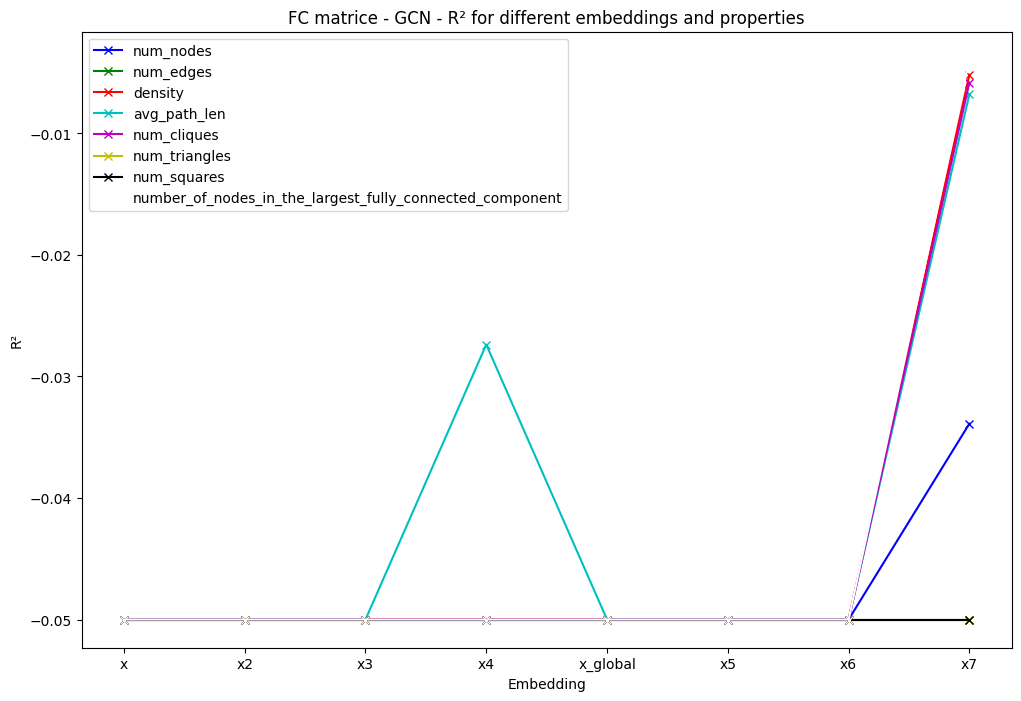

In [11]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x_global', 'x5', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()
